# Projektna naloga pri Uvodu v programiranje
## Pridobivanje podatkov

Za dostop do informacij o točkah ELO (ter tudi nekaterih drugih podatkih) najboljših 100 šahistov med leti 2000 ter 2024, bomo uporabljali spletišče Mednarodne šahovske federacije (FIDE): https://ratings.fide.com/. O spletišču pa najprej omenim naslednje zanimivosti:

Tipična URL povezava do tabele o najboljših šahistih neke kategorije za dani mesec je oblike: https://ratings.fide.com/toparc.phtml?cod=1 ; kjer končnica cod parametrizira zaporedni vnos podatkov. Opaziomo, da v odvisnosti od num modulo 4 dobimo sledeče kategorije šahistov:

|   cod    |  mod 4  |
| -------- | ------- |
|    1     | odprta kategorija   |
|    2     | ženska kategorija     |
|    3     | kategorija juniorjev   |
|    4     | kategorija juniork |

Za vrednost cod=1 pa dobimo tabelo s podatki o najboljših 100 šahistih v odprti sekciji za mesec julij leta 2000, za vrednost cod=5 dobimo tabelo s podatki o najboljših šahistih v odpri sekciji za mesec oktober leta 2000 ipd.

Z nekaj ročne analize (ter z pomočjo bisekcije) ugotovimo, da so med julijem leta 2000 (cod=1) in julijem leta 2009 (cod=145) tabelo objavljali vsake tri mesece (januar, april, julij ter oktober); nakar je prišlo do spremembe. Od septembra 2009 (cod=149) do maja 2012 (cod=213) pa so tabelo objavljali vsak drugi mesec (januar, marec, maj, julij, september, november), nato pa so prešli na trenutni sistem mesečnih objav tabel, ki velja od julija 2012 (cod=217).

|   Pogostost    |  Trajanje  | cod |
| -------- | ------- | --------- |
|    3x letno     |  julij 2000 - julij 2009  | 1 - 145 |
|    6x letno     | september 2009 - maj 2012 | 145 - 217|
|    12x letno    | julij 2012 - | 217  - |

To sicer ni preveč relevantno za pridobivanje podatkov, saj informacijo o datumu pridobimo tako, da preberemo HTML, je pa relevantno za analizo podatkov. Ker se količina informacij, ki jih imamo za npr. leto 2000 (le dve tabeli) občutno razlikuje od količine informacij, ki jih imamo za leto 2023 (12 tabel) in ker pri računanju povprečja uporabimo preprosto aritmetično sredino je pričakovano, da bodo povprečja bolj reprezentativna kasnejših podatkov.

Za uspešno pridobivanje podatkov sledite navodilom v datoteki ```README.md```

In [1]:
import pandas as pd
import os
from statistics import mean
import matplotlib.pyplot as plt
import funkcije
import analiza_funkcije as af

pot_plitka = os.getcwd()
pot_globoka =  os.path.join(pot_plitka, 'podatkovna_baza')
pot_sahisti = os.path.join(pot_plitka, 'sahisti')

Preden začnemo z analizo podatkov opazimo, da so nekatera imena v podatkovni bazi podvojena; primer je Garry Kasparov ter Gary Kasparov. Do tega pride, ker so občasno imena v FIDE podatkovni bazi zapisana z kakšno črko razlike ali pa z dodatnim/odvečnim drugim imenom.

Ker pa si želimo, da podatke, ki očitno pripadajo istemu šahistu analiziramo kot take, bomo vse .csv datoteke, za katere menimo, da predstavljajo istega šahista, združili. Najprej zberemo imena, za katera mislimo, da pripadajo isti osebi v seznam seznamov imen.

In [2]:
ekvivalence = [['Sadler, Matthew', 'Sadler, Matthew D'],['Dominguez Perez, Lenier', 'Dominguez Perez, Leinier'],['Kasparov, Gary', 'Kasparov, Garry'], ['Bologan, Victor', 'Bologan, Viktor'], ['Bruzon, Lazaro', 'Bruzon Batista, Lazaro'], ['Dreev, Alexey', 'Dreev, Aleksey'], ['Harikrishna, Pentala', 'Harikrishna, P'], ['Iturrizaga, Eduardo', 'Iturrizaga Bonelli, Eduardo'], ['Ivanchuk, Vassily', 'Ivanchuk, Vasyl'], ['Kobalia, Mikhail', 'Kobalija, Mihail'], ['Mamedyarov, Shakhriyar', 'Mamedyarov, Shakhriyaz'], ['Narayanan S L', 'NarayananSL'], ['Polgar, Judit (GM)', 'Polgar, Judit'], ['Shankland, Sam', 'Shankland, Samuel', 'Shankland, Samuel L']]
nova_imena = [ime[0] for ime in ekvivalence]

#af.popravljalnik(ekvivalence, nova_imena)

Odlično, sedaj smo opravili z podvojenimi (ter v enem primeru potrojenimi) podatki.

## Analiza podatkov
Sedaj si poglejmo nekaj zbranih podatkov.

In [3]:
sahisti_prikaz_df = pd.DataFrame(af.pridobi_splosne_informacje(), columns=['Ime', 'Leto rojstva', 'Drzava', 'Najvišji rating'])

sahisti_prikaz_df.head(15)

,Ime,Leto rojstva,Drzava,Najvišji rating
0,"Kramnik, Vladimir",1975,RUS,2817
1,"Anand, Viswanathan",1969,IND,2817
2,"Morozevich, Alexander",1977,RUS,2788
3,"Adams, Michael",1971,ENG,2761
4,"Shirov, Alexei",1972,ESP,2755
5,"Leko, Peter",1979,HUN,2763
6,"Ivanchuk, Vassily",1969,UKR,2787
7,"Topalov, Veselin",1975,BUL,2816
8,"Krasenkow, Michal",1963,POL,2702
9,"Bareev, Evgeny",1966,RUS,2739


Prva stvar ki nas zanima je pri kateri starosti šahisti dosežejo svoj vrhunec. Postopek, da pridobimo to informacijo bo naslednji:
1. Ustvarili bomo kopijo seznama sahisti ter v to kopijo shranili podatke o tem pri kateri starosti šahist doseže svoj največji ELO rating; podobno bomo naredili tudi z podatkom pri kateri starosti šahist doseže svoj največji indeks na lestvici najboljših 100 šahistov. Ta podatka nista nujno enakovredna, zaradi rating inflationa ([relevanten wikipedia snippet](https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details)).
2. Statistično analizirali zbrano.
3. Zbrane podatke grafično prikazali.

Naš prvi korak bo, da analiziramo ELO šahista v odvisnosti od starosti šahista. To bomo storili tako, da za vsakega šahista, o katerim imamo informacije, izračunamo rating pri določeni starosti ter te podatke predstavimo z diagramom.

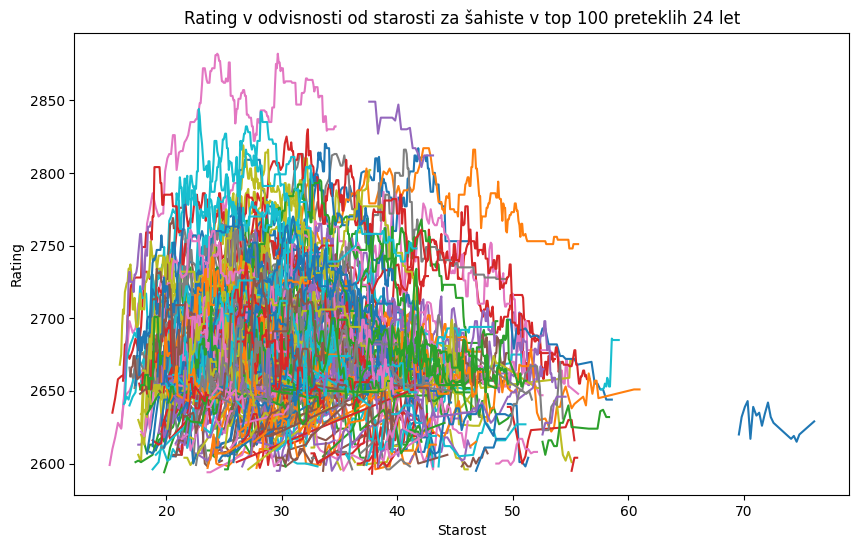

In [4]:
plt.figure(figsize=(10,6))
for kljucni_nabor, podatki in af.podatki_top_nekaj(100).items():
    #Seznam podatkov o datumih nadomestimo z seznamom podatkov starosti posameznega šahista
    podatki_starost = [round(funkcije.datum_v_float(datum) - kljucni_nabor[1],2) for datum in podatki['datum']]
    plt.plot(podatki_starost, podatki['rating'], label = kljucni_nabor[0])
plt.title('Rating v odvisnosti od starosti za šahiste v top 100 preteklih 24 let')
plt.xlabel('Starost')
plt.ylabel('Rating')
plt.show()

Diagram žal ni najbolj berljiv. Kako pa se obnaša povprečni šahist v naši populaciji?

V zgornji celici smo izluščili informacije o ELO ratingov šahistov ob starostih, za celotno populacijo šahistov. Morda pa bi dobili bolj berljive informacije, če bi enako naredili za celotno populacijo šahistov, za katere imamo informacije, ter nato te podatke povprečili.

Pri tej starosti povprečni šahist v naši populaciji doseže svoj najvišji rating: 31. 
Ta rating je 2703.


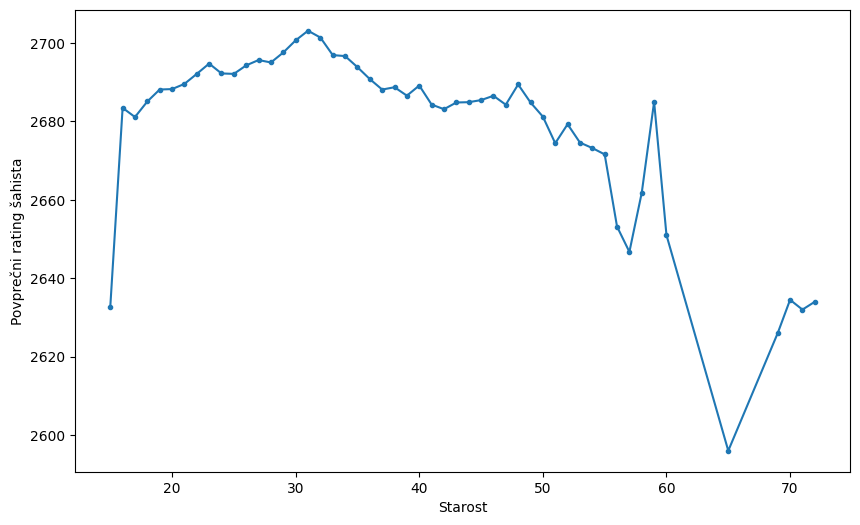

In [5]:
povprecje_v_populaciji_100 = af.povprecje_v_populaciji(100)
maksimum_v_populaciji_100 = af.maksimum_v_povprecju_populacije(povprecje_v_populaciji_100, 100)[0]
najvisji_rating_v_populaciji_100 = af.maksimum_v_povprecju_populacije(povprecje_v_populaciji_100, 100)[1]

formatirani_ekstrem_100 = ' ,'.join(f'{stevilo}' for stevilo in maksimum_v_populaciji_100)
print(f'Pri tej starosti povprečni šahist v naši populaciji doseže svoj najvišji rating: {formatirani_ekstrem_100}. \nTa rating je {najvisji_rating_v_populaciji_100}.')


pandas_prikaz_top_100 = pd.Series(povprecje_v_populaciji_100)

plt.figure(figsize=(10,6))

pandas_prikaz_top_100.plot(kind = 'line', marker = '.')
plt.xlabel('Starost')
plt.ylabel('Povprečni rating šahista')
plt.show()

Morda pa nas naše elitistične težnje vodijo do tega, da bi si radi ogledali še podatke le o najboljših izmed najboljših. Poglejmo si iste informacije na populaciji šahistov, ki so v svoji karieri dosegli mesto med najboljšimi 5 šahisti na FIDE lestvici.

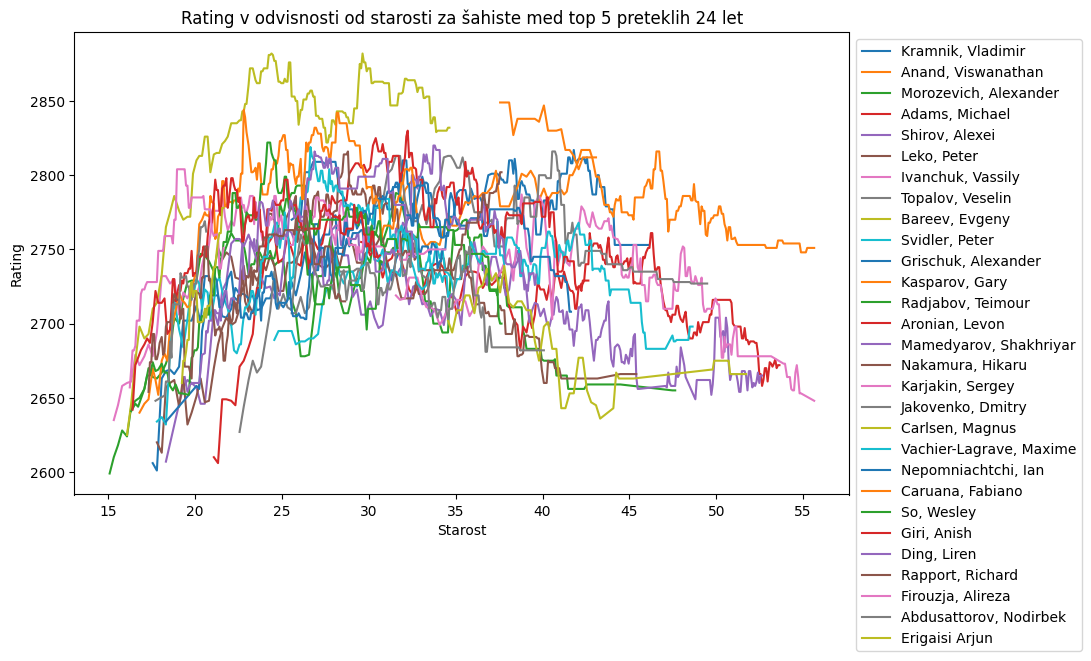

In [6]:
plt.figure(figsize=(10,6))
for kljucni_nabor, podatki in af.podatki_top_nekaj(5).items():
    #Seznam podatkov o datumih nadomestimo z seznamom podatkov starosti posameznega šahista
    podatki_starost = [round(funkcije.datum_v_float(datum) - kljucni_nabor[1],2) for datum in podatki['datum']]
    plt.plot(podatki_starost, podatki['rating'], label = kljucni_nabor[0])
plt.title('Rating v odvisnosti od starosti za šahiste med top 5 preteklih 24 let')
plt.legend(bbox_to_anchor = (1,1))
plt.xlabel('Starost')
plt.ylabel('Rating')
plt.show()

Sedaj še povprečje te demografike.

Pri tej starosti povprečni šahist, ki je dosegel mesto med najboljšimi petimi šahisti na svetu, doseže svoj najvišji rating: 28. 
Ta rating je 2772.


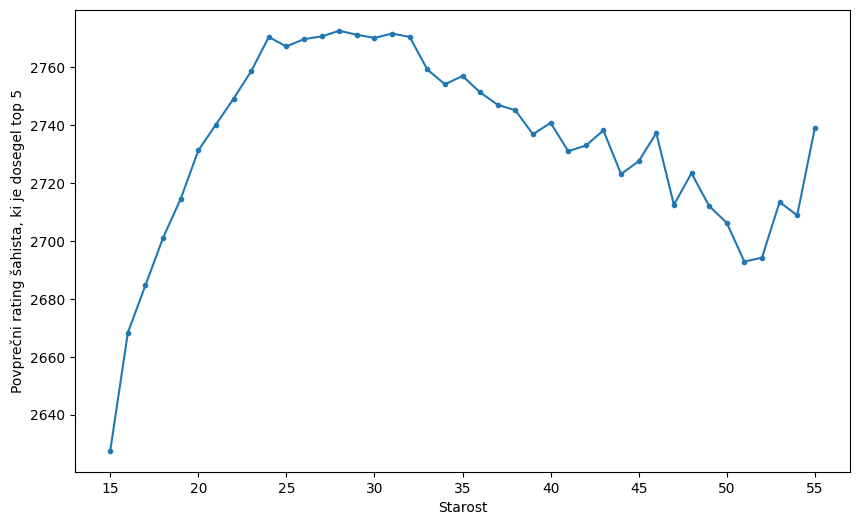

In [7]:
povprecje_v_populaciji_5 = af.povprecje_v_populaciji(5)
maksimum_v_populaciji_5 = af.maksimum_v_povprecju_populacije(povprecje_v_populaciji_5, 5)[0]
najvisji_rating_v_populaciji_5 = af.maksimum_v_povprecju_populacije(povprecje_v_populaciji_5, 5)[1]

formatirani_ekstrem_5 = ' ,'.join(f'{stevilo}' for stevilo in maksimum_v_populaciji_5)
print(f'Pri tej starosti povprečni šahist, ki je dosegel mesto med najboljšimi petimi šahisti na svetu, doseže svoj najvišji rating: {formatirani_ekstrem_5}. \nTa rating je {najvisji_rating_v_populaciji_5}.')

pandas_prikaz_top_5 = pd.Series(povprecje_v_populaciji_5)

plt.figure(figsize=(10,6))

pandas_prikaz_top_5.plot(kind = 'line', marker = '.')

plt.xlabel('Starost')
plt.ylabel('Povprečni rating šahista, ki je dosegel top 5')
plt.show()

Kaj pa le tisti, ki imajo v neki točki v času najvišji ELO na svetu? Zaradi majhne količine podatkov bi jih lahko kar vse razpisali.

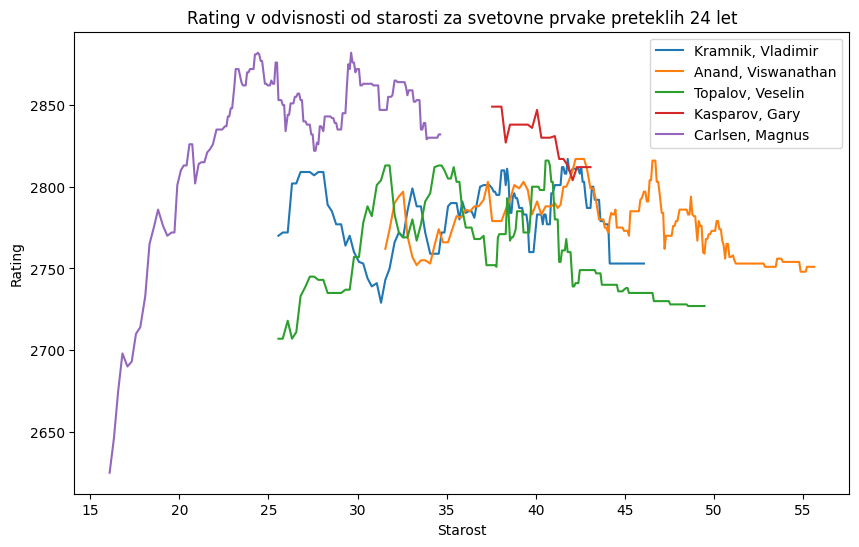

In [8]:
plt.figure(figsize=(10,6))
for kljucni_nabor, podatki in af.podatki_top_nekaj(1).items():
    #Seznam podatkov o datumih nadomestimo z seznamom podatkov starosti posameznega šahista
    podatki_starost = [round(funkcije.datum_v_float(datum) - kljucni_nabor[1],2) for datum in podatki['datum']]
    plt.plot(podatki_starost, podatki['rating'], label = kljucni_nabor[0])
plt.title('Rating v odvisnosti od starosti za svetovne prvake preteklih 24 let')
plt.legend(bbox_to_anchor = (1,1))
plt.xlabel('Starost')
plt.ylabel('Rating')
plt.show()

In ponovno v povprečju.

Pri tej starosti povprečni šahist, ki je dosegel prvo mesto na svetu, doseže svoj najvišji rating: 24. 
Ta rating je 2873.


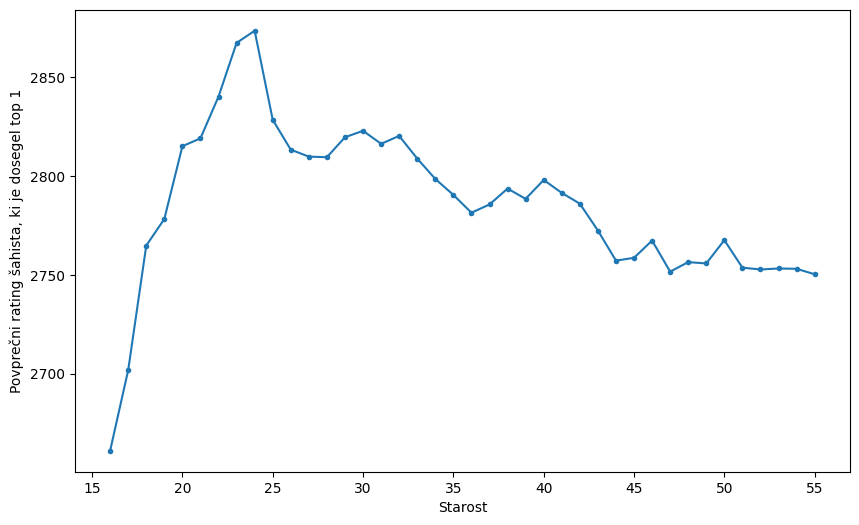

In [9]:
povprecje_v_populaciji_1 = af.povprecje_v_populaciji(1)
maksimum_v_populaciji_1 = af.maksimum_v_povprecju_populacije(povprecje_v_populaciji_1, 1)[0]
najvisji_rating_v_populaciji_1 = af.maksimum_v_povprecju_populacije(povprecje_v_populaciji_1, 1)[1]

formatirani_ekstrem_1 = ' ,'.join(f'{stevilo}' for stevilo in maksimum_v_populaciji_1)
print(f'Pri tej starosti povprečni šahist, ki je dosegel prvo mesto na svetu, doseže svoj najvišji rating: {formatirani_ekstrem_1}. \nTa rating je {najvisji_rating_v_populaciji_1}.')

pandas_prikaz_top_1 = pd.Series(povprecje_v_populaciji_1)

plt.figure(figsize=(10,6))

pandas_prikaz_top_1.plot(kind = 'line', marker = '.')

plt.xlabel('Starost')
plt.ylabel('Povprečni rating šahista, ki je dosegel top 1')
plt.show()

Iz čiste radovednosti narišimo grafe povprečnega šahista v naši podatkovni bazi, povprečnega šahista, ki je dosegel rating med top 5, ter šahista, ki je dosegel rang 1, na isti diagram.

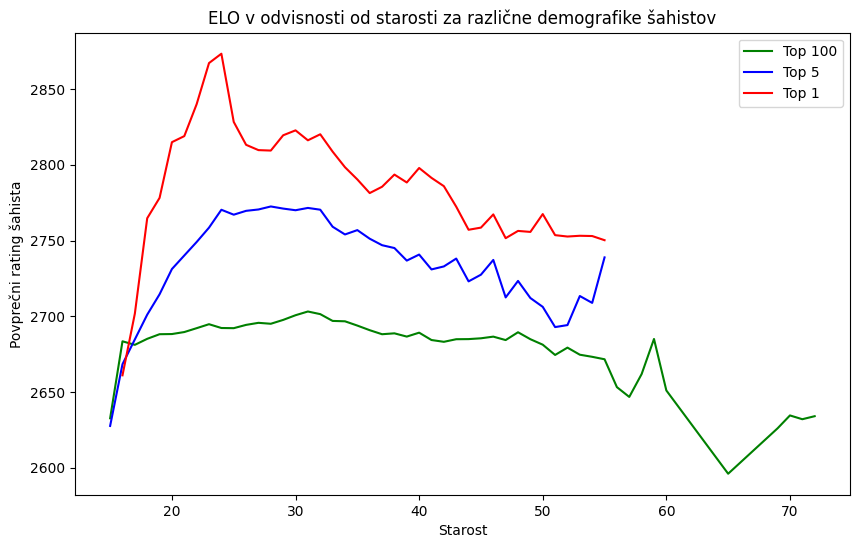

In [10]:
plt.figure(figsize=(10,6))

pandas_prikaz_top_100.plot(label='Top 100', color='green')
pandas_prikaz_top_5.plot(label='Top 5', color='blue')
pandas_prikaz_top_1.plot(label='Top 1', color='red')

plt.xlabel('Starost')
plt.ylabel('Povprečni rating šahista')
plt.title('ELO v odvisnosti od starosti za različne demografike šahistov')

plt.legend()
plt.show()

Preden nadaljujemo pa je treba dodati, da naša statistična analiza ni brez svojih primanjkljajev. Ker so nam na voljo le podatki o šahistih med letom 2000 in letom 2024, so zbrani podatki o šahistih, ki so bili na lestvici tudi pred letom 2000, nereprezentativni. Seveda, mar res pričakujemo, da se je (kot lahko vidimo na grafu 'Rating v odvisnosti od starosti za svetovne prvake preteklih 24 let') Gary Kasparov kar pojavil z ELO ratingom čez 2800?

|Demografika| Najvišji rating | Starost pri najvišjem ratingu|
|-----------|-----------------|------------------------------|
|Povprečje populacije top 100 šahistov| 2703 | 31 |
|Povprečje populacije top 5 šahistov| 2772 | 28 |
|Povprečje populacije top 1 šahistov| 2873 | 24 |

Vidimo, da se razvoj šahistovega ELO ratinga skozi njegovo življenje zelo razlikuje, če vemo, da dotični šahist doseže mesto med najboljšimi 100 (zelena črta), najboljšimi 5 (morda črta), ter najboljši med vsemi (rdeča črta). Ne samo da 'boljši' šahisti dosegajo svoj maksimum pri višjih ratingih, kar je samoumevno, tudi dosegajo ga kot mlajši, in to ne za zanemarljivo količino.

Do sedaj pa se še nismo poslužili enega izmed podatkov, ki smo jih zbrali. To je namreč država, pod zastavo katere igra posamezni šahist.
Pojavljajo se nam naslednja vprašanja:
* Kakšen delež šahistov predstavljajo posamezne države?
* Ali obstaja povezava med šahistovo državo ter njegovim rangom oz. ratingom?

Lotimo se najprej prve točke.

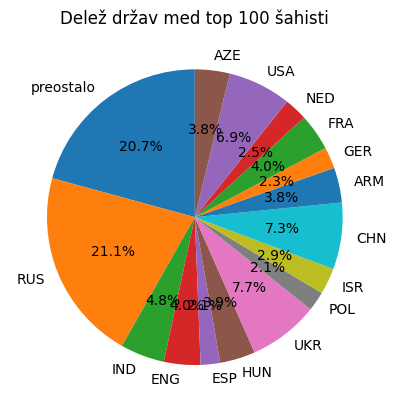

In [15]:
pogostost_drzav, prazne_drzave, stevilo_podatkov, meja  = af.drzave_splosne_informacije()

pogostost_drzav_nad_mejo, drzave_nad_mejo = af.pogostost_drzav_nad_mejo(pogostost_drzav, meja)

pogostost_drzav_nad_mejo_pandas = pd.Series(pogostost_drzav_nad_mejo)

pogostost_drzav_nad_mejo_pandas.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Delež držav med top 100 šahisti')
plt.ylabel('')
plt.show()

Naredimo še en bolj berljiv tortni diagram, ki ne vsebuje procentov.

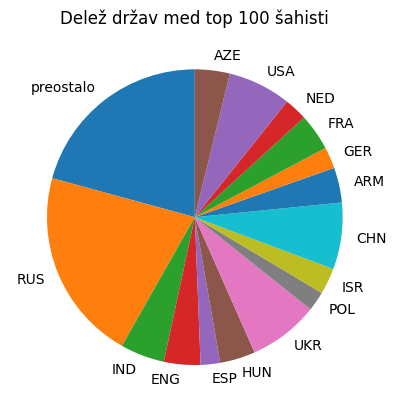

In [16]:
pogostost_drzav_nad_mejo_pandas.plot.pie(startangle=90)
plt.title('Delež držav med top 100 šahisti')
plt.ylabel('')
plt.show()

Lotimo se še druge točke: kakšna je povezava med šahistovo državo ter njegovim ratingom?

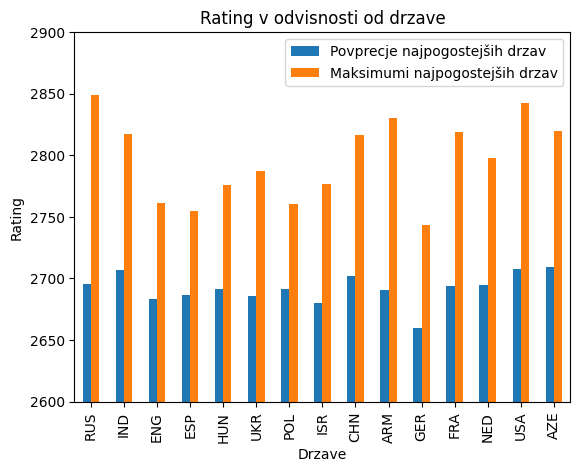

In [17]:
drzave = af.ustvarjalec_drzav(prazne_drzave)
drzave_nad_mejo_info = af.informacije_o_mnozici_drzav(drzave_nad_mejo, drzave)
drzave_nad_mejo_v_povprecju = af.kalkulator_povprecja(drzave_nad_mejo_info)
drzave_nad_mejo_maksimumi = af.ustvarjalec_maksimumom_drzav(drzave_nad_mejo_info)

drzave_nad_mejo_v_povprecju_df = pd.DataFrame({'Povprecje najpogostejših drzav': drzave_nad_mejo_v_povprecju, 'Maksimumi najpogostejših drzav' : drzave_nad_mejo_maksimumi})

drzave_nad_mejo_v_povprecju_df.plot(kind = 'bar')
plt.ylim(2600, 2900)
plt.title('Rating v odvisnosti od drzave')
plt.xlabel('Drzave')
plt.ylabel('Rating')
plt.legend()
plt.show()

Nazoren diagram, a žal ne prepoznamo katere izmed držav so najboljše v posamezni metriki. 
ZDA, Azerbajdžan, Kitajska ter Indija so navidezno izenačeni pri modrih stolpcih, Rusija, ZDA ter Armenija pa pri oranžnih stolpcih.
Napišimo nekaj vrstic kode, ki razjasni situacijo.

In [18]:
povprecje_drzave_v_tekmovanju = {i : drzave_nad_mejo_v_povprecju[i] for i in {'IND', 'CHN', 'USA', 'AZE'}}
print(f'Naslednje so točne informacije o povprečnem ratingu igralcev nekaterih držav: {povprecje_drzave_v_tekmovanju}')

maksimumi_drzave_v_tekomvanju = {i : drzave_nad_mejo_maksimumi[i] for i in {'RUS', 'USA', 'ARM'}}
print(f'Naslednje so točne informacije o najvišjem ratingu igralcev nekaterih držav: {maksimumi_drzave_v_tekomvanju}')

Naslednje so točne informacije o povprečnem ratingu igralcev nekaterih držav: {'USA': 2707.58, 'IND': 2706.67, 'AZE': 2709.25, 'CHN': 2701.65}
Naslednje so točne informacije o najvišjem ratingu igralcev nekaterih držav: {'USA': 2842, 'RUS': 2849, 'ARM': 2830}
